<img src='./img/BGC-ARGO-LOGO.jpg' alt='' align='centre' width='20%'></img>
<div style="text-align: right"><i> BBP AUDIT - Raphaëlle Sauzède - November 2020 </i></div>

***

<center><h2> BGC-ARGO BBP AUDIT FROM SOCA-BBP CMEMS PRODUCT </h2></center>

<center><h3> How to flag bad bbp profiles from a reference database? </h3></center>

***

# Import libraries

First, for avoiding the warning messages during the execution and installation process, at first remove them:

In [1]:
import warnings
warnings.filterwarnings('ignore')

Import all libraries and functions that we need for the program:

In [2]:
import os
#import os.path
from os import path
import numpy as np
import pandas as pd
import wget
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.basemap import Basemap
from datetime import date
from datetime import datetime
from datetime import timedelta
from netCDF4 import Dataset as NetCDFFile 
from netCDF4 import num2date
from sklearn.metrics import mean_squared_error
from scipy.stats import ttest_ind, mannwhitneyu, bartlett, ks_2samp

# Define working paths

In [3]:
path_data_home="/home/sauzede/Documents/R/DATA/"
path_bbp_clim_data="/media/sauzede/MyPassport/DATA/FOR_SOCA_PRODUCT/WEEKLY_FIELDS/CLIMATO/SOCA-BBP/"
path_argo_data="/home/sauzede/ARGO_DATA/"
#path_argo_data="/media/sauzede/MyPassport/ARGO_DATA/"
path_plot="/home/sauzede/PYTHON/ml4ocean/AUDIT_BBP/PLOT/"

# Load synthetic Argo index file from coriolis and get dac/wmo/n_cycle for each NecCDF file from the BGC-Argo database

Download the synthetic Argo index file (with information on Real Time/ Adjusted and Delayed mode parameters for Synthetic NetCDF files) from coriolis for the date of today.

In [4]:
#date_today=str(date.today())
# Stop the 23th of November to present the BBP audit during ADMT 
date_audit_pres_ADMT=str("2020-11-23")

# Download file if it was not doine already for today
if not path.exists(path_data_home + "/index_bio_synth_" + date_audit_pres_ADMT + ".txt"):
    print('Beginning file download with wget module')
    url='ftp://ftp.ifremer.fr/ifremer/argo/argo_synthetic-profile_index.txt'
    wget.download(url, path_data_home + "/index_bio_synth_" + date_today + ".txt")

In [5]:
# Read this file
INDEX_SYNTH=pd.read_table(path_data_home + "/index_bio_synth_" + date_audit_pres_ADMT + ".txt", skiprows=8, sep=",", encoding='utf8')

In [6]:
INDEX_SYNTH.columns

Index(['file', 'date', 'latitude', 'longitude', 'ocean', 'profiler_type',
       'institution', 'parameters', 'parameter_data_mode', 'date_update'],
      dtype='object')

Get dac/WMO/n_cycle/measured variables associated to each NetCDF file:

In [7]:
files = INDEX_SYNTH['file'] #pathways of all profiles
file=files.str.split("/", expand=True).rename(columns={0:'dac', 1:'wod', 3:'ncdf'}) 
INDEX_SYNTH['dac']=file.dac
INDEX_SYNTH['wod']=file.wod
INDEX_SYNTH['ncdf']=file.ncdf
# print(file)
nc_cycle=file.ncdf.str.split("_",expand=True)[1].str.split(".",expand=True)[0]
INDEX_SYNTH['nc_cycle']=nc_cycle
# print(nc_cycle)
variable = INDEX_SYNTH['parameters'] #contains parameters measured by the float
variables=variable.str.split()
variables=variables.astype(str)
INDEX_SYNTH['variables']=variables
# print(variables)
ref_date = "19500101000000"
INDEX_SYNTH['datetime'] = pd.to_datetime(INDEX_SYNTH['date'],format='%Y%m%d%H%M%S', errors='ignore') # convert date column to datetime
#INDEX_SYNTH.head()

# Compute the statistics between CMEMS weekly climatologies of bbp and bbp measured from floats

First, get all climatological dates (every week) from the name of clim files:

In [8]:
# Directory of bbp climatological data :
nc_file_chemin_bbp_clim=os.listdir(path_bbp_clim_data)
# Get all dates for clim: split the name of the NetCDf file to retrieve the date into it:
dates_of_clim=[nc_file_chemin_bbp_clim[i].split("_")[6] for i in range(len(nc_file_chemin_bbp_clim)-1)]
# And remove TOOOOOZ from the date:
dates_of_clim=[dates_of_clim[i].split("T")[0] for i in range(len(dates_of_clim)-1)]
# Transform the string in date formats:
dates_of_clim = [datetime.strptime(str(dates_of_clim[i]),'%Y%m%d') for i in range(len(dates_of_clim)-1)]

In [9]:
print("There are " + str(len(nc_file_chemin_bbp_clim)) + " weekly climatological dates")

There are 53 weekly climatological dates


Then, initialize the statistical variables to fill in the INDEX_SYNTH dataframe and varibales to retrieve the number of bbp profiles compared to the bbp climatologies:

In [10]:
# QC for profile
INDEX_SYNTH['PROF_QC']=np.nan

# Stats variables computed from difference between Argo and clim ref
# Median Absolute Percent Difference - MAPD
INDEX_SYNTH['MAPD']=np.nan 
# Median Percent Difference - MPD
INDEX_SYNTH['MPD']=np.nan 
# Median Difference - MD
INDEX_SYNTH['MD']=np.nan 
# Median Gain -MG
INDEX_SYNTH['MG']=np.nan
# Root Mean Squared Difference - RMSD
INDEX_SYNTH['RMSD']=np.nan

# Results of p-value from different stats tests
#INDEX_SYNTH['Chi2']=np.nan 
#INDEX_SYNTH['Wilcoxon']=np.nan 
INDEX_SYNTH['T-test_ind']=np.nan 
#INDEX_SYNTH['T-test_rel']=np.nan 
#INDEX_SYNTH['Welch']=np.nan 
INDEX_SYNTH['Kolomogorov-Smirnov']=np.nan 
INDEX_SYNTH['Mann-Whitney']=np.nan 
INDEX_SYNTH['Bartlett']=np.nan 

# Index of bbp profiles
i_bbp=[]
i_bbp_good_profile=[]
i_bbp_good_profile_clim=[]

In [11]:
print("Total of " + str(len(files)) + " files")

Total of 210895 files


In [14]:
for i in range(len(files)-1):

    if i in [50000,100000,150000,200000]:
        print(str(i) + "/" + str(len(files)))
    
    # We want only open Argo files when bbp has been measured from the float
    if not "BBP700" in variables[i]:
        # Pass if BBP not measured
        continue
    
    # Get full path name of the NetCDF file
    path_bbp_argo_file=path_argo_data + files[i]
    
    # Verify that the file exists (sometimes problem between the index file and files in the database 
    # because the update is not finished in files available)
    if not path.exists(path_bbp_argo_file):
        # Pass if the file does not exist
        continue
        
    # Put the i in the bbp_i vector to store indices of files that exist with BBP700 measured
    i_bbp.append(i)
    
    # Open the Argo NetCDF file
    bgc_data=NetCDFFile(path_bbp_argo_file)
    # Get bbp/pres and geolocation variables and their associated QC
    bbp_argo=bgc_data.variables['BBP700'][:][0]
    bbp_argo_qc=bgc_data.variables['BBP700_QC'][:][0]
    # The QC variables has to be decoded
    bbp_argo_qc=[np.array(bbp_argo_qc)[i].decode('utf-8') for i in range(len(bbp_argo))]
           
    # Get pressure
    pres_argo=bgc_data.variables['PRES'][:][0]
    pres_argo_qc=bgc_data.variables['PRES_QC'][:][0]
    # Decode the QC of pressure
    pres_argo_qc=[np.array(pres_argo_qc)[i].decode('utf-8') for i in range(len(pres_argo))]
           
    # Get lon/lat/juld and QC associated
    lon_argo=bgc_data.variables['LONGITUDE'][:]
    lat_argo=bgc_data.variables['LATITUDE'][:]
    position_qc=bgc_data.variables['POSITION_QC'][:]
    position_qc=str(position_qc[0].decode('utf-8'))
        
    juld=bgc_data.variables['JULD']
    # Transfor the juld date in date format
    datetime_juld=num2date(juld[:],juld.units)
    juld_qc=bgc_data.variables['JULD_QC'][:]
    juld_qc=str(juld_qc[0].decode('utf-8'))

    # Get month and day from the date
    month=datetime_juld[:][0].strftime('%m')
    day=datetime_juld[:][0].strftime('%d')

    # Remove Fillvalues of bbp in pres and bbp variables
    pres_argo=pres_argo[bbp_argo.mask==False]
    pres_argo_qc=np.array(pres_argo_qc)[bbp_argo.mask==False]
    bbp_argo_qc=np.array(bbp_argo_qc)[bbp_argo.mask==False]
    bbp_argo=bbp_argo[bbp_argo.mask==False]
    
    # Verify that there are some data of bbp and that the position and date are not bad QC flagged data
    if (len(bbp_argo)<1) or (not position_qc in ['1','2']) or (not juld_qc in ['1','2']):
        # If no bbp data or bad position and/or date:
        # Close the NetCDF file
        bgc_data.close() 
        # And pass to next iteration
        continue
    
    # Increment i_bbp_good_profile if bbp profile with at least one value is available with good position and date available
    i_bbp_good_profile.append(i)
         
    # Get the QC from bbp profile
    prof_qc=bgc_data.variables['PROFILE_BBP700_QC'][:]
    if not prof_qc.mask:
        prof_qc_str=str(prof_qc[0].decode('utf-8'))
    if prof_qc.mask:
        prof_qc_str=np.nan
    
    # Put the prof QC in the dataframe
    INDEX_SYNTH['PROF_QC'][i]=prof_qc_str
    
    # Close the Argo NetCDF file
    bgc_data.close() 
               
    # Get the closest date of climatology available
    # For that, get the date of the profile (month/day) but for year 2018
    # If wrong date (i.e.29/02) --> change in 28/02
    if month=='02' and day=="29":
        day='28'
    else:
        new_date=datetime.strptime(str('2018'+month+day),'%Y%m%d')

    # Compute the time difference between the date of float (in 2018) and each climatological date (in 2018)
    delta=[abs(dates_of_clim[i]-new_date) for i in range(len(dates_of_clim)-1)]
    # Retrieve the minimum of the time difference
    i_min=np.argmin(delta)
    # Get the path of the NetCDF file associated to the climatological data for the minimum time difference
    path_bbp_clim_data_w = path_bbp_clim_data + nc_file_chemin_bbp_clim[i_min]
    # Open the climatological NetCDF file
    nc_bbp_clim=NetCDFFile(path_bbp_clim_data_w)
    # Get pres/bbp and location from the climatological product
    bbp_clim=nc_bbp_clim.variables["bbp"][:]
    pres_clim=nc_bbp_clim.variables["depth"][:]
    lon_clim=nc_bbp_clim.variables["longitude"][:]
    lat_clim=nc_bbp_clim.variables["latitude"][:]
    # Close climatological NetCDF file
    nc_bbp_clim.close()
                
    # Get the closest pixel associated to the float profile
    # Compute the difference between each lon/lat and position of the float to retrieve the position of the minimum
    delta_lon=[abs(lon_clim[i]-lon_argo) for i in range(len(lon_clim)-1)]
    iii=np.argmin(delta_lon)
    delta_lat=[abs(lat_clim[i]-lat_argo) for i in range(len(lat_clim)-1)]
    jjj=np.argmin(delta_lat)
    # Get the bbp values (at 19 depths) value for the minimum of difference for lon and lat
    bbp_clim_comp=bbp_clim[0,:,jjj,iii]

    # Verify that the climatological bbp profile is not empty
    if not bbp_clim_comp.mask.all():
        # Interpolate the bbp climatological values to Argo pressure
        bbp_clim_comp_approx=np.interp(x=pres_argo,xp=pres_clim,fp=bbp_clim_comp)

        # Compute statistics between bbp clim and bbp from Argo
        # Median Absolute Difference
        MAPD=np.median(abs((bbp_argo - bbp_clim_comp_approx)/bbp_clim_comp_approx))*100
        # Median Percent Difference
        MPD=np.median((bbp_argo - bbp_clim_comp_approx)/bbp_clim_comp_approx)*100
        # Median Difference
        MD=np.median(bbp_argo - bbp_clim_comp_approx)
        # Median gain
        MG=np.median(bbp_clim_comp_approx/bbp_argo)
        # Mean Squared Difference
        msd = mean_squared_error(y_true=bbp_clim_comp_approx,y_pred=bbp_argo)
        # Root Mean Squared Difference
        RMSD = np.sqrt(msd)
        
        # Put these statistics in the dataframe
        INDEX_SYNTH['MAPD'][i]=MAPD
        INDEX_SYNTH['MPD'][i]=MPD
        INDEX_SYNTH['MD'][i]=MD
        INDEX_SYNTH['MG'][i]=MG
        INDEX_SYNTH['RMSD'][i]=RMSD

        if len(bbp_argo)>5:
            # Statistics tests --> Get p-value
            INDEX_SYNTH['T-test_ind'][i]=ttest_ind(bbp_argo, bbp_clim_comp_approx)[1]
            INDEX_SYNTH['Kolomogorov-Smirnov'][i]=ks_2samp(bbp_argo, bbp_clim_comp_approx)[1]
            INDEX_SYNTH['Mann-Whitney'][i]=mannwhitneyu(bbp_argo, bbp_clim_comp_approx)[1]
            INDEX_SYNTH['Bartlett'][i]=bartlett(bbp_argo, bbp_clim_comp_approx)[1]
              
        # Increment i_bbp_good_profile_clim if bbp climatology available with bbp Argo profile
        i_bbp_good_profile_clim.append(i)

50000/210895
100000/210895
150000/210895
200000/210895


In [12]:
INDEX_SYNTH.shape

(210895, 26)

In [13]:
INDEX_SYNTH.columns

Index(['file', 'date', 'latitude', 'longitude', 'ocean', 'profiler_type',
       'institution', 'parameters', 'parameter_data_mode', 'date_update',
       'dac', 'wod', 'ncdf', 'nc_cycle', 'variables', 'datetime', 'PROF_QC',
       'MAPD', 'MPD', 'MD', 'MG', 'RMSD', 'T-test_ind', 'Kolomogorov-Smirnov',
       'Mann-Whitney', 'Bartlett'],
      dtype='object')

# Results

## Some numbers

In [14]:
print("BBP700 is measured for " + str(len(i_bbp)) + " files / " + str(len(files)) + " available")

BBP700 is measured for 73262 files / 210895 available


In [19]:
print(str(len(i_bbp_good_profile)) + 
      " good BBP700 profiles available (with at least one value and with good QC flagged position and date)")

73262 good BBP700 profiles available (with at least one value and with good QC flagged position and date)


In [20]:
print(str(len(i_bbp_good_profile_clim)) + " climatological profiles of bbp available to make the comparison")

60096 climatological profiles of bbp available to make the comparison


Plot the geolocation of profiles without climatological data:

In [21]:
i_without_clim = np.setdiff1d(i_bbp_good_profile,i_bbp_good_profile_clim)

In [22]:
print(str(len(i_without_clim)) + " climatological profiles of bbp not available to make the comparison")

13165 climatological profiles of bbp not available to make the comparison


## Plot the geographical distribution of the climatological weekly bbp profiles not available

 Global Ocean:

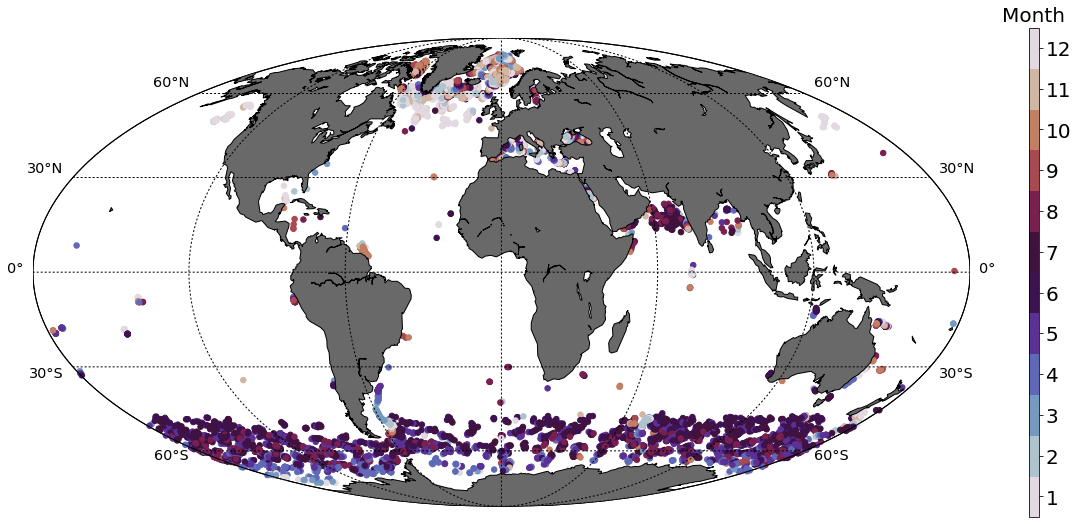

In [23]:
fig = plt.figure(figsize=(21,9)) # set figure environemnt
m = Basemap(projection="moll",lon_0=0,resolution='c') # Plot geographical map and define projection

# Get date  of data that we want to plot
juld = INDEX_SYNTH['date'][i_without_clim]
# Transform the juld date in date format
datetime_juld=[datetime.strptime(str(int(juld[i_without_clim[i]])), "%Y%m%d%H%M%S") for i in np.arange(len(i_without_clim))]

# Get month and day from the date
month=[int(datetime_juld[:][i].strftime('%m')) for i in np.arange(len(datetime_juld))]

# Get lon/lat of data that we want to plot:
lon = INDEX_SYNTH['longitude'][i_without_clim].tolist()
lat = INDEX_SYNTH['latitude'][i_without_clim].tolist()

LON,LAT = m(lon,lat) #transform lon/lat in the basemap environment

cmap = plt.cm.twilight
norm = BoundaryNorm(np.linspace(start=0.5,stop=12.5,num=13), cmap.N)
sc = plt.scatter(LON, LAT, s=30, c=month, facecolors="none",cmap=cmap,norm=norm) #facecolors = "none" to have circles (empty)

#plot continents/coastlines...
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='dimgrey',lake_color='white')
m.drawparallels(np.arange(-90.,90.,30.),labels=[True,True,False,False],dashes=[2,2], fontsize='x-large')
m.drawmeridians(np.arange(-180.,180.,60.),labels=[False,False,False,True],dashes=[2,2])
cbar = plt.colorbar(sc, aspect=50, ticks=[1,2,3,4,5,6,7,8,9,10,11,12])
cbar.ax.set_yticklabels(["1","2","3","4","5","6","7","8","9","10","11","12"], fontsize=20)
cbar.ax.set_title("Month", fontsize=20) #Add a title to the colorbar

plt.savefig('%s/MAP_DATA_MISSING_CLIMATO_GLOBAL.png' %str(path_plot), dpi=300) #Save the figure as png

Zoom Mediterranean Sea:

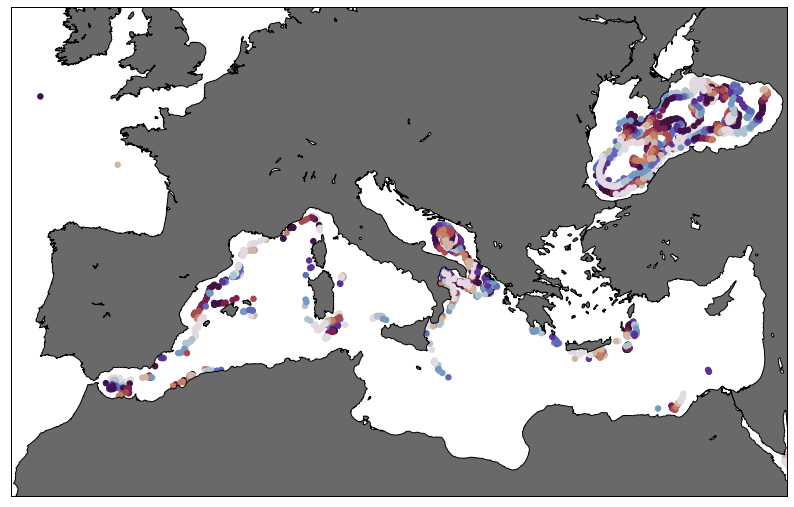

In [24]:
fig = plt.figure(figsize=(15,9)) # set figure environemnt
m = Basemap(projection="cass",lon_0=0, lat_0 = 39.5, resolution='i',
           llcrnrlon=-10,llcrnrlat=30,urcrnrlon=45.,urcrnrlat=45.) # Plot geographical map and define projection

# Get date  of data that we want to plot
juld = INDEX_SYNTH['date'][i_without_clim]
# Transform the juld date in date format
datetime_juld=[datetime.strptime(str(int(juld[i_without_clim[i]])), "%Y%m%d%H%M%S") for i in np.arange(len(i_without_clim))]

# Get month and day from the date
month=[int(datetime_juld[:][i].strftime('%m')) for i in np.arange(len(datetime_juld))]

# Get lon/lat of data that we want to plot:
lon = INDEX_SYNTH['longitude'][i_without_clim].tolist()
lat = INDEX_SYNTH['latitude'][i_without_clim].tolist()

LON,LAT = m(lon,lat) #transform lon/lat in the basemap environment

cmap = plt.cm.twilight
norm = BoundaryNorm(np.linspace(start=0.5,stop=12.5,num=13), cmap.N)
sc = plt.scatter(LON, LAT, s=30, c=month, facecolors="none",cmap=cmap,norm=norm) #facecolors = "none" to have circles (empty)

plt.xlim(-10.5,  45)
plt.ylim(30, 45)
# plot continents/coastlines...
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='dimgrey',lake_color='white')
#m.drawlsmask(land_color='dimgrey',ocean_color='white',lakes=True)

plt.savefig('%s/MAP_DATA_MISSING_CLIMATO_MED_SEA.png' %str(path_plot), dpi=300) #Save the figure as png

## Find statistics for BBP Audit

Save the dataframe:

In [25]:
INDEX_SYNTH.to_csv("INDEX_SYNTH_BBP_ALL.csv", index=False)

Get data:

In [15]:
INDEX_BBP_ALL=pd.read_csv("INDEX_SYNTH_BBP_ALL.csv")

In [16]:
INDEX_BBP_ALL.columns

Index(['file', 'date', 'latitude', 'longitude', 'ocean', 'profiler_type',
       'institution', 'parameters', 'parameter_data_mode', 'date_update',
       'dac', 'wod', 'ncdf', 'nc_cycle', 'variables', 'datetime', 'PROF_QC',
       'MAPD', 'MPD', 'MD', 'MG', 'RMSD', 'T-test_ind', 'Kolomogorov-Smirnov',
       'Mann-Whitney', 'Bartlett'],
      dtype='object')

In [17]:
print(str(len(INDEX_BBP_ALL['MAPD'].dropna())) + " profiles have been compared to a reference bbp climatological profile")

60096 profiles have been compared to a reference bbp climatological profile


Remove data without bbp (when MAPD has not been computed so is NaN:

In [18]:
INDEX_BBP=INDEX_BBP_ALL.dropna(subset=['MAPD'])

In [19]:
INDEX_BBP.shape

(60096, 26)

## Boxplots of statistics against profile QC

Profile QC:

| **Profile QC** | **Meaning** |
| :---: | :---|
| **" "** | No QC performed |
| **A** | **N**=100%; All profile levels contain good data |
| **B** | 75% <= **N** < 100% |
| **C** | 50% <= **N** < 75% |
| **D** | 25% <= **N** < 50% |
| **E** | 0% < **N** < 25% |
| **F** | **N** = 0%; No profile levels have good data |

Boxplots:

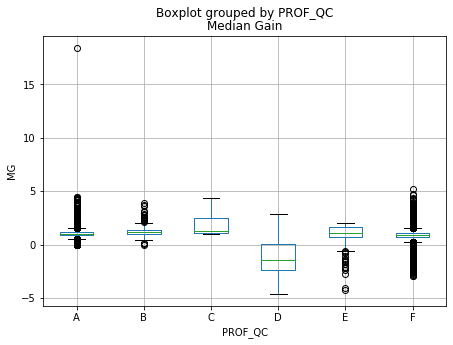

In [20]:
boxplot = INDEX_BBP.boxplot(column='MG',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Median Gain'
plt.title( title_boxplot )
boxplot.set_ylabel('MG')
plt.savefig('%s/BOXPLOT_MG.png' %str(path_plot), dpi=300) #Save the figure as png

Text(0, 0.5, 'MAPD')

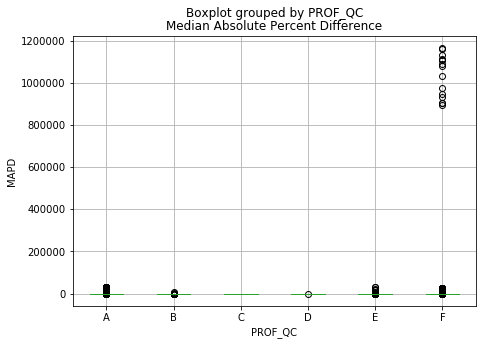

In [21]:
boxplot = INDEX_BBP.boxplot(column='MAPD',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Median Absolute Percent Difference'
plt.title( title_boxplot )
boxplot.set_ylabel('MAPD')

(0, 300)

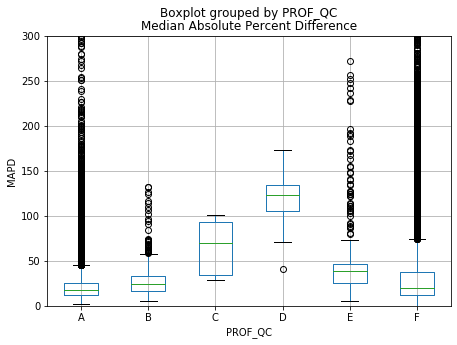

In [22]:
boxplot = INDEX_BBP.boxplot(column='MAPD',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Median Absolute Percent Difference'
plt.title( title_boxplot )
boxplot.set_ylabel('MAPD')
plt.ylim(0,300)

(0, 0.002)

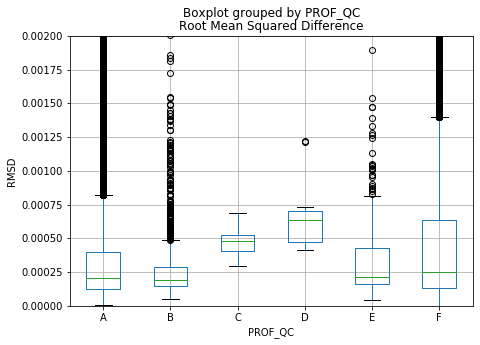

In [23]:
boxplot = INDEX_BBP.boxplot(column='RMSD',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Root Mean Squared Difference'
plt.title( title_boxplot )
boxplot.set_ylabel('RMSD')
plt.ylim(0,0.002)

Text(0, 0.5, 'P-value T-test')

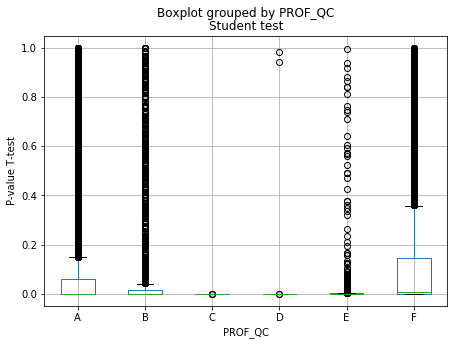

In [24]:
boxplot = INDEX_BBP.boxplot(column='T-test_ind',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Student test'
plt.title( title_boxplot )
boxplot.set_ylabel('P-value T-test')

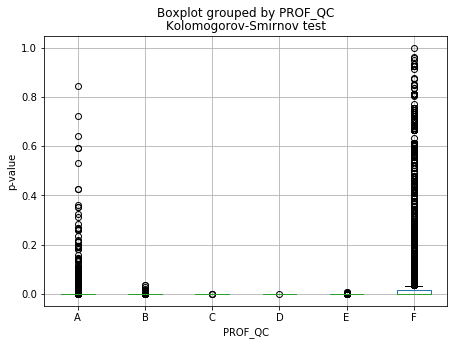

In [25]:
boxplot = INDEX_BBP.boxplot(column='Kolomogorov-Smirnov',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Kolomogorov-Smirnov test'
plt.title( title_boxplot )
boxplot.set_ylabel('p-value')
plt.savefig('%s/BOXPLOT_KOLOMOGOROV.png' %str(path_plot), dpi=300) #Save the figure as png

Text(0, 0.5, 'p-value')

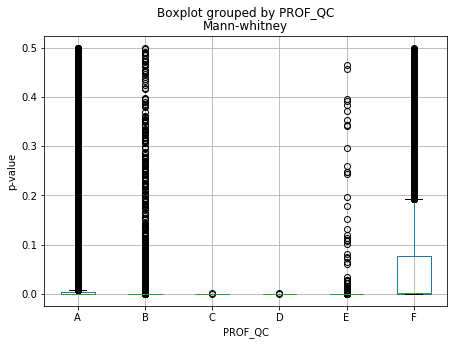

In [26]:
boxplot = INDEX_BBP.boxplot(column='Mann-Whitney',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Mann-whitney'
plt.title( title_boxplot )
boxplot.set_ylabel('p-value')

Text(0, 0.5, 'p-value')

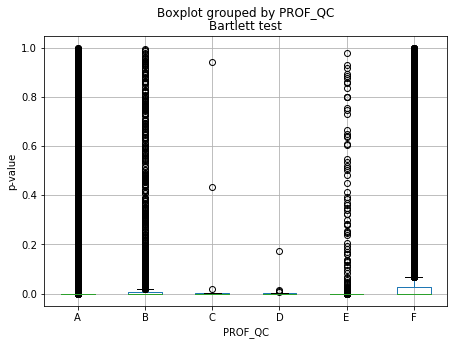

In [27]:
boxplot = INDEX_BBP.boxplot(column='Bartlett',by='PROF_QC', figsize=(7,5))
title_boxplot = 'Bartlett test'
plt.title( title_boxplot )
boxplot.set_ylabel('p-value')

## Compute the Median Absolute Deviation (MAD, DOXY AUDIT inspiration)

Define the stats used to check "bad?" bbp profiles


First with MAPD:

In [30]:
M = np.median(INDEX_BBP['MAPD'])
Manom = np.abs(INDEX_BBP['MAPD'] - M)
MAD = np.median(Manom*1.4826)
print("With MAPD M+5*MAD is equal to :", M+5*MAD)

With MAPD M+5*MAD is equal to : 86.95314545303506


Second with Median Gain:

In [31]:
M = np.median(INDEX_BBP['MG'])
Manom = np.abs(INDEX_BBP['MG'] - M)
MAD = np.median(Manom*1.4826)
Z = Manom/MAD
print("With MG M+5*MAD is equal to :", M+5*MAD, "and M-5*MAD is equal to :", M-5*MAD)

With MG M+5*MAD is equal to : 2.204091426693074 and M-5*MAD is equal to : -0.27091488430772825


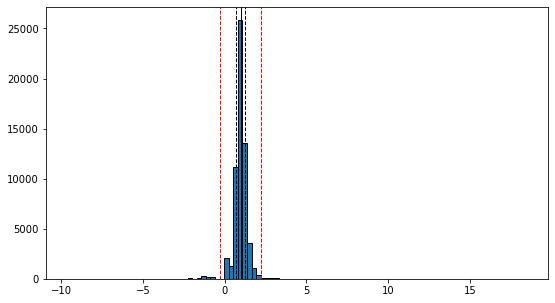

In [32]:
fig = plt.figure(figsize=(9,5)) # set figure environemnt
plt.hist(INDEX_BBP['MG'], bins=100, edgecolor="black")
plt.axvline(M, color="black", linewidth=1)
plt.axvline(M-MAD, color="black", linewidth=1, linestyle='--')
plt.axvline(M+MAD, color="black", linewidth=1, linestyle='--')
plt.axvline(M-5*MAD, color="red", linewidth=1, linestyle='--')
plt.axvline(M+5*MAD, color="red", linewidth=1, linestyle='--')

**--> I checked the results with MAPD and MG and it was not concluent --> a lot of false positive anomalous profiles**

With Median percent difference:

In [33]:
M = np.median(INDEX_BBP['MPD'])
Manom = np.abs(INDEX_BBP['MPD'] - M)
MAD = np.median(Manom*1.4826)
Z = Manom/MAD
INDEX_BBP['Z'] = Z

Histogram:

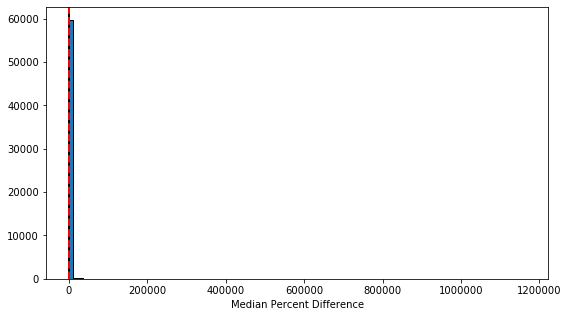

In [34]:
fig = plt.figure(figsize=(9,5)) # set figure environemnt
plt.hist(INDEX_BBP['MPD'], bins=100, edgecolor="black")
plt.xlabel('Median Percent Difference')
plt.axvline(M, color="black", linewidth=2)
plt.axvline(M-MAD, color="black", linewidth=2, linestyle='--')
plt.axvline(M+MAD, color="black", linewidth=2, linestyle='--')
plt.axvline(M-5*MAD, color="red", linewidth=2, linestyle='--')
plt.axvline(M+5*MAD, color="red", linewidth=2, linestyle='--')
plt.savefig('%s/HIST_MPD_ALL_RANGE.png' %str(path_plot), dpi=300) #Save the figure as png

Zoom:

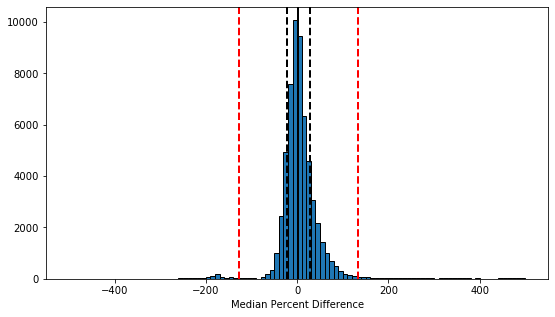

In [35]:
fig = plt.figure(figsize=(9,5)) # set figure environemnt
plt.hist(INDEX_BBP['MPD'], range=(-500, 500), bins=100, edgecolor="black")
plt.xlabel('Median Percent Difference')
plt.axvline(M, color="black", linewidth=2)
plt.axvline(M-MAD, color="black", linewidth=2, linestyle='--')
plt.axvline(M+MAD, color="black", linewidth=2, linestyle='--')
plt.axvline(M-5*MAD, color="red", linewidth=2, linestyle='--')
plt.axvline(M+5*MAD, color="red", linewidth=2, linestyle='--')
plt.savefig('%s/HIST_MPD.png' %str(path_plot), dpi=300) #Save the figure as png

In [36]:
print("With MPD M+5*MAD is equal to :", M+5*MAD, "and M-5*MAD is equal to :", M-5*MAD)

With MPD M+5*MAD is equal to : 132.18398862607077 and M-5*MAD is equal to : -127.0805010519011


In [37]:
INDEX_BBP_TO_CHECK=INDEX_BBP[(INDEX_BBP['MPD']<M-5*MAD) | (INDEX_BBP['MPD']>M+5*MAD)]

In [38]:
INDEX_BBP_TO_CHECK.describe()

,date,latitude,longitude,profiler_type,date_update,wod,MAPD,MPD,MD,MG,RMSD,T-test_ind,Kolomogorov-Smirnov,Mann-Whitney,Bartlett,Z
count,3.424000e+03,3424.000000,3424.000000,3424.000000,3.424000e+03,3.424000e+03,3.424000e+03,3.424000e+03,3424.000000,3424.000000,3424.000000,3.175000e+03,3.175000e+03,3.175000e+03,3.175000e+03,3424.000000
mean,2.015954e+13,-0.520538,26.534041,840.379089,2.020108e+13,5.738707e+06,8.292154e+03,8.206388e+03,0.022763,-0.192127,0.025886,2.623921e-04,1.428843e-06,3.904544e-06,2.459769e-02,319.779074
std,2.722193e+10,40.634336,70.702454,7.576814,4.055391e+07,1.748926e+06,6.884859e+04,6.885887e+04,0.146733,0.643338,0.178573,1.415080e-02,4.315662e-05,5.110115e-05,1.190830e-01,2655.529928
min,2.010101e+13,-70.517000,-174.763000,835.000000,2.020103e+13,1.901329e+06,1.270904e+02,-3.329768e+02,-0.001538,-3.096541,0.000302,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000381
25%,2.014022e+13,-45.457750,-25.766250,836.000000,2.020103e+13,3.902123e+06,1.919717e+02,1.408113e+02,0.000462,0.003611,0.000920,0.000000e+00,3.185299e-287,2.175391e-159,5.632613e-300,7.459116
50%,2.016042e+13,9.767500,6.383500,836.000000,2.020110e+13,6.901152e+06,5.887699e+02,5.887699e+02,0.002099,0.029084,0.002453,3.861635e-245,4.291412e-150,6.692086e-89,1.431741e-53,22.610815
75%,2.018111e+13,31.084750,95.986750,846.000000,2.020111e+13,6.901646e+06,4.148851e+03,4.148851e+03,0.015280,0.157637,0.018803,2.712232e-68,1.334852e-39,4.133016e-24,8.254180e-09,159.925441
max,2.020112e+13,72.642000,179.581000,869.000000,2.020112e+13,7.900562e+06,1.164383e+06,1.164383e+06,2.202066,0.456795,5.857028,7.971948e-01,2.164502e-03,1.729802e-03,9.721947e-01,44910.903276


In [39]:
# When adding MG and Kolomogorov test:
INDEX_BBP_TO_CHECK=INDEX_BBP[(INDEX_BBP['MPD']<M-5*MAD) | (INDEX_BBP['MPD']>M+5*MAD) | (INDEX_BBP['Kolomogorov-Smirnov']>=0.9) | (INDEX_BBP['MG']<0)]

In [40]:
INDEX_BBP_TO_CHECK.shape

(3496, 27)

In [42]:
print("Significant Kolomogorov-Smirnov test and negative Median Gain add", 3496-3424, "profiles")

Significant Kolomogorov-Smirnov test and negative Median Gain add 72 profiles


## Pie plots for anomalous bbp profiles found per dac + time series of anomalous profiles per year for each dac

First, pie plots of all bbp profiles per dac:

coriolis    23816
aoml        13888
incois       9051
csiro        7721
bodc         3534
csio         1371
jma           715
Name: dac, dtype: int64


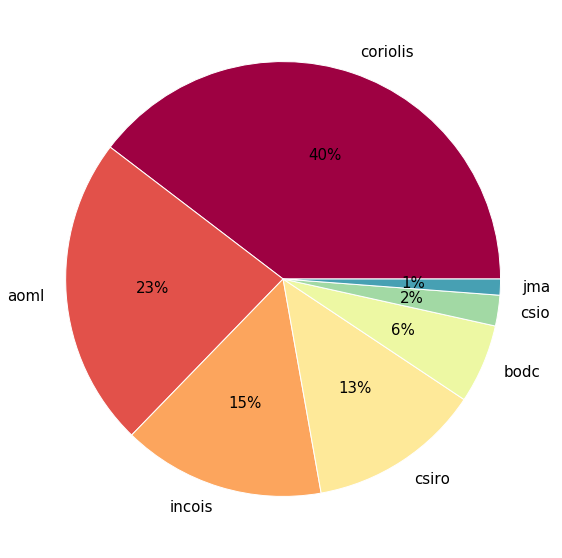

In [43]:
fig = plt.figure(figsize=(10,10)) # set figure environemnt
dac_counts = INDEX_BBP['dac'].value_counts()
labels = INDEX_BBP['dac'].value_counts().index.tolist()
print(dac_counts)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.rcParams['font.size'] = 15

plt.pie(dac_counts, labels = labels, colors = colors, autopct='%.0f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.savefig('%s/PIE_PLOT_BBP_PROFILES.png' %str(path_plot), dpi=300) #Save the figure as png

Second, all anomalous profiles for all the database:

coriolis    1699
csiro        740
bodc         523
incois       348
aoml         137
jma           40
csio           9
Name: dac, dtype: int64


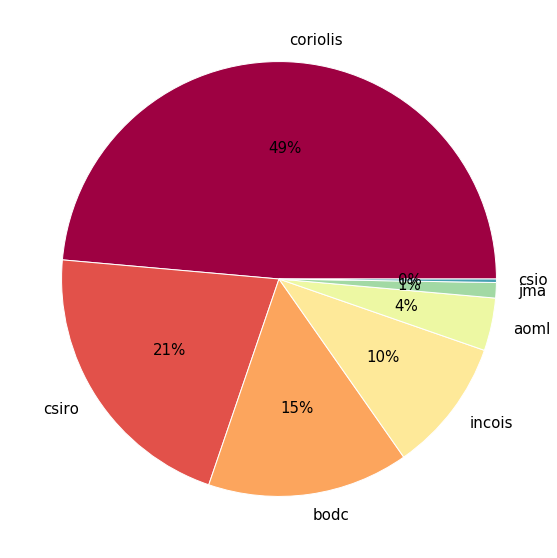

In [44]:
fig = plt.figure(figsize=(10,10)) # set figure environemnt
dac_counts = INDEX_BBP_TO_CHECK['dac'].value_counts()
labels = INDEX_BBP_TO_CHECK['dac'].value_counts().index.tolist()
print(dac_counts)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.rcParams['font.size'] = 15
plt.pie(dac_counts, labels = labels, colors = colors, autopct='%.0f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.savefig('%s/PIE_PLOT_BAD_PROFILES.png' %str(path_plot), dpi=300) #Save the figure as png

coriolis
csiro
bodc
incois
aoml
jma
csio


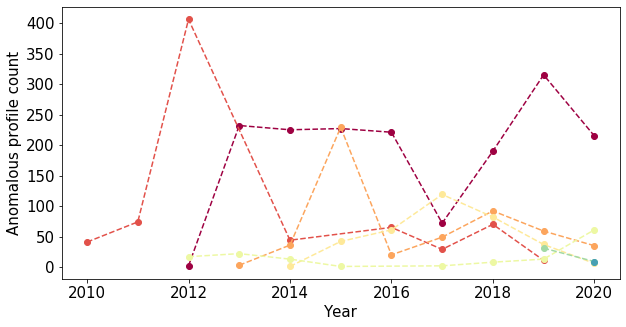

In [45]:
# Get date of data that we want to plot
juld = INDEX_BBP_TO_CHECK['date']
# Transform the juld date in date format
datetime_juld=[datetime.strptime(str(int(juld[i])), "%Y%m%d%H%M%S") for i in juld.index.values]

# Get year from the date
year=[int(datetime_juld[:][i].strftime('%Y')) for i in np.arange(len(datetime_juld))]
# Put it in the dataframe
INDEX_BBP_TO_CHECK['Year']=year

fig = plt.figure(figsize=(10,5)) # set figure environemnt
dac_year_counts = INDEX_BBP_TO_CHECK.groupby(["dac", "Year"]).size()
i=0
for d in INDEX_BBP_TO_CHECK['dac'].value_counts().index.tolist():
    print(d)
    plt.plot(dac_year_counts[d], color=colors[i], linestyle='--', marker='o')
    plt.ylabel("Anomalous profile count")
    plt.xlabel("Year")
    i+=1
plt.savefig('%s/YEAR_ANOMALOUS_BAD_PROFILES.png' %str(path_plot), dpi=300) #Save the figure as png

In [46]:
print(str(INDEX_BBP_TO_CHECK[(INDEX_BBP_TO_CHECK['PROF_QC']=='D') | (INDEX_BBP_TO_CHECK['PROF_QC']=='E') | (INDEX_BBP_TO_CHECK['PROF_QC']=='F')].shape[0])
      + " are bad profiles FOR SURE on a total of " + str(INDEX_BBP_TO_CHECK.shape[0]) + " profiles")

2058 are bad profiles FOR SURE on a total of 3496 profiles


In [47]:
print(str(round(2058/3496*100)) + " % of profiles are bad FOR SURE")

59 % of profiles are bad FOR SURE


Validation of the method: Removal of all already bad flagged profiles to set up the BBP audit

In [48]:
INDEX_BBP_GOOD = INDEX_BBP[~((INDEX_BBP['PROF_QC']=='D') | (INDEX_BBP['PROF_QC']=='E') | ( INDEX_BBP['PROF_QC']=='F'))]
M = np.median(INDEX_BBP_GOOD['MPD'])
Manom = np.abs(INDEX_BBP_GOOD['MPD'] - M)
MAD = np.median(Manom*1.4826)
Z = Manom/MAD
INDEX_BBP_TO_CHECK_GOOD=INDEX_BBP_GOOD[(INDEX_BBP_GOOD['MPD']<M-5*MAD) | (INDEX_BBP_GOOD['MPD']>M+5*MAD) | 
                                       (INDEX_BBP_GOOD['Kolomogorov-Smirnov']>=0.9) | (INDEX_BBP_GOOD['MG']<0)]
print("With MPD for good flagged profiles M+5*MAD is equal to :", M+5*MAD, "and M-5*MAD is equal to :", M-5*MAD)

With MPD for good flagged profiles M+5*MAD is equal to : 128.72805440947667 and M-5*MAD is equal to : -125.88349346834237


Pie plot for these new bad profiles:

csiro       707
bodc        363
incois      214
coriolis    146
jma          33
csio          1
Name: dac, dtype: int64


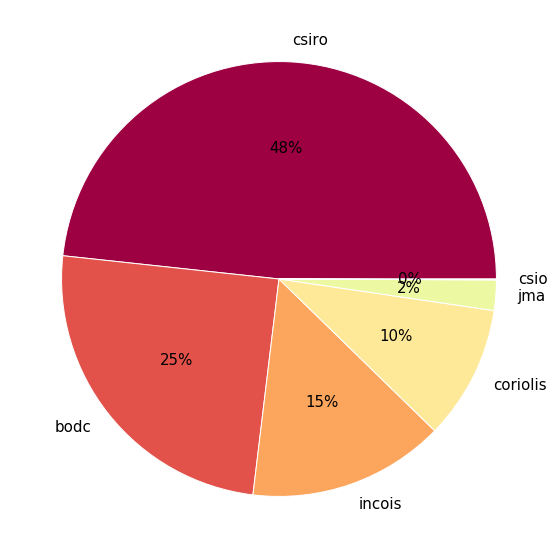

In [49]:
fig = plt.figure(figsize=(10,10)) # set figure environemnt
dac_counts = INDEX_BBP_TO_CHECK_GOOD['dac'].value_counts()
labels = INDEX_BBP_TO_CHECK_GOOD['dac'].value_counts().index.tolist()
print(dac_counts)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
plt.rcParams['font.size'] = 15
plt.pie(dac_counts, labels = labels, colors = colors, autopct='%.0f%%', wedgeprops = {"linewidth": 1, "edgecolor": "white"})
plt.savefig('%s/PIE_PLOT_NEW_BAD_PROFILES.png' %str(path_plot), dpi=300) #Save the figure as png

Plot time series of number of bad profiles per year for each dac:

csiro
bodc
incois
coriolis
jma
csio


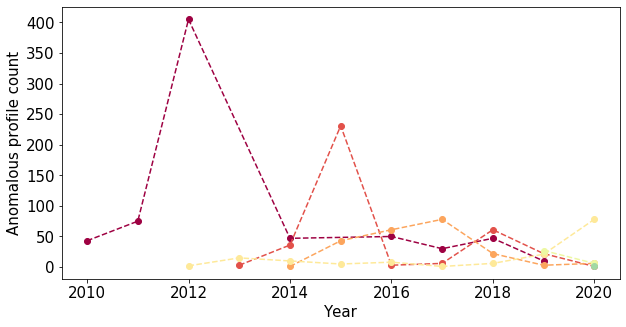

In [50]:
# Get date of data that we want to plot
juld = INDEX_BBP_TO_CHECK_GOOD['date']
# Transform the juld date in date format
datetime_juld=[datetime.strptime(str(int(juld[i])), "%Y%m%d%H%M%S") for i in juld.index.values]

# Get year from the date
year=[int(datetime_juld[:][i].strftime('%Y')) for i in np.arange(len(datetime_juld))]
# Put it in the dataframe
INDEX_BBP_TO_CHECK_GOOD['Year']=year

fig = plt.figure(figsize=(10,5)) # set figure environemnt
dac_year_counts = INDEX_BBP_TO_CHECK_GOOD.groupby(["dac", "Year"]).size()
i=0
for d in INDEX_BBP_TO_CHECK_GOOD['dac'].value_counts().index.tolist():
    print(d)
    plt.plot(dac_year_counts[d], color=colors[i], linestyle='--', marker='o')
    plt.ylabel("Anomalous profile count")
    plt.xlabel("Year")
    i+=1
plt.savefig('%s/YEAR_ANOMALOUS_BAD_NEW_PROFILES.png' %str(path_plot), dpi=300) #Save the figure as png

# Save the data

In [51]:
INDEX_BBP_TO_CHECK.columns

Index(['file', 'date', 'latitude', 'longitude', 'ocean', 'profiler_type',
       'institution', 'parameters', 'parameter_data_mode', 'date_update',
       'dac', 'wod', 'ncdf', 'nc_cycle', 'variables', 'datetime', 'PROF_QC',
       'MAPD', 'MPD', 'MD', 'MG', 'RMSD', 'T-test_ind', 'Kolomogorov-Smirnov',
       'Mann-Whitney', 'Bartlett', 'Z', 'Year'],
      dtype='object')

In [52]:
INDEX_BBP_TO_CHECK_TO_SAVE=INDEX_BBP_TO_CHECK[['file', 'date', 'latitude', 'longitude', 'institution', 'parameters', 'parameter_data_mode', 'date_update',
       'dac', 'wod', 'ncdf', 'nc_cycle', 'variables', 'MPD', 'MG', 'Kolomogorov-Smirnov', 'PROF_QC']]

In [126]:
#INDEX_BBP_TO_CHECK_TO_SAVE.to_csv("INDEX_SYNTH_BBP_TO_CHECKv2.csv", index=False)
INDEX_BBP_TO_CHECK_TO_SAVE.to_csv("INDEX_SYNTH_BBP_TO_CHECK_MAD_MPD.csv", index=False)